In [200]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten, Reshape


import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [208]:
import kagglehub

path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /Users/dl/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [242]:
from scipy.ndimage import zoom
import numpy as np

def resize_images(x, new_shape=(32, 32)):
    resized_x = np.zeros((x.shape[0], new_shape[0], new_shape[1]))
    for i in range(x.shape[0]):
        resized_x[i] = zoom(x[i], (new_shape[0] / x.shape[1], new_shape[1] / x.shape[2]), order=1)
    return resized_x

def load_fashion_mnist(path):
    train_df = pd.read_csv(os.path.join(path, 'fashion-mnist_train.csv'))
    test_df = pd.read_csv(os.path.join(path, 'fashion-mnist_test.csv'))

    x_train, y_train = train_df.drop(columns=['label']).values, train_df['label'].values
    x_test, y_test = test_df.drop(columns=['label']).values, test_df['label'].values

    x_train = x_train.reshape(-1, 28, 28)
    x_test = x_test.reshape(-1, 28, 28)

    x_train = resize_images(x_train, (32, 32))
    x_test = resize_images(x_test, (32, 32))

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_fashion_mnist(path)

print(x_train.shape[0], 'train samples')
print('image shape', x_train[0].shape)

60000 train samples
image shape (32, 32)


In [246]:
import numpy as np
import matplotlib.pyplot as plt

input_dim = 1024
x_train = x_train.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])

# normalization
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

input shape:  1024


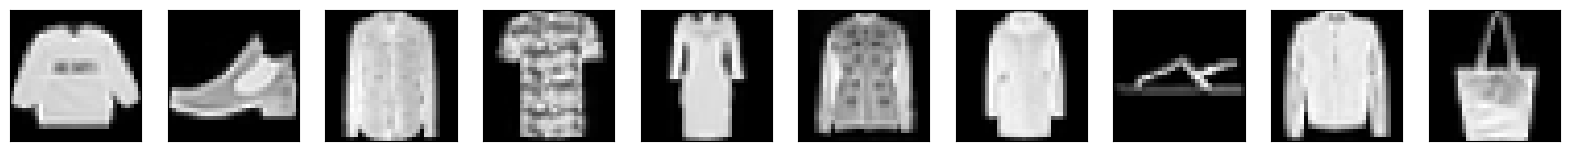

In [250]:
n = 10
img_shape = 32
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    img = x_train[i].reshape(img_shape, img_shape)
    plt.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### build

In [285]:
latent_dim = 100

def build_generator():
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model  

In [287]:
def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [289]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()


In [291]:
def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0] / batch_size)
    for ep in range(epochs + 1):
        for i in range(num_batches):
            # Generate random noise for the generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            
            # Get a random batch of real images
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            # Reshape to (batch_size, 32, 32, 1) for grayscale images and normalize
            image_batch = image_batch.reshape(batch_size, 32, 32, 1)  # Reshape to (batch_size, 32, 32, 1)
            image_batch = (image_batch.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
            
            # Convert grayscale to RGB (repeat the grayscale channel 3 times)
            image_batch = np.repeat(image_batch, 3, axis=-1)  # Now shape will be (batch_size, 32, 32, 3)
            
            # Generate fake CIFAR images using the generator
            generated_images = generator.predict(noise)
            
            # Concatenate the real and generated images for the discriminator
            X = np.concatenate([image_batch, generated_images])

            # Labels for real and generated images (using label smoothing for the real images)
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9  # Label smoothing trick (instead of using 1.0)
            
            # Train the discriminator
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train the generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)  # Labels for the generator (fake images should be classified as real)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        # Every 10 epochs, print and plot generated images
        if ep % 10 == 0:
            print('Epoch:', ep)
            plot_generated_images(ep, generator)


In [293]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)


epochs = 50 # to get good quality images, you should train the model for more than 100 epochs
batch_size = 128
train_model(epochs, batch_size)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'